# COGS 118A - Project Checkpoint

# Names
- Dhathry Doppalapudi | A16298078
- Serina Khanna | A15851279
- Niko Calsada | A15352545

# Abstract 
The goal of our project is to predict beer future beer prices in Russia. This can be used by Russian bars and breweries to help them price their beers. The data used is from a craft beer bar in Russia and has variables such as product name, retail price, size, country of origin, and alcohol by volume (ABV). We will be using the data to understand how these variables affect the price and predict how the price of craft beer will change in the future. Performance will be measured by how low our error metrics such as mean squared error and mean absolute error are. 

# Background
Since COVID-19 began to spread in March 2020, supply chain issues for various products have increased and many industries have been affected. Among restaurants, there was a significant labor shortage and home delivery systems became more popular <a name="forbes"></a>[<sup>[5]</sup>](#forbes). While these new options are definitely more popular among consumers, a lack of in-person customers have affected establishments that rely on people buying their products in-person, such as establishments that sell alcohol. In addition, the war in Ukraine and inflation have impacted the alcohol industry, with 20% of the world’s barley coming from Ukraine and beer prices rising slightly<a name="war"></a>[<sup>[1]</sup>](#war). In addition, given that our data is from a Russian bar, it’s possible that our data has been impacted by the Russian-Ukrainian war as many people boycotted Russian alcohol<a name="mccormick"></a>[<sup>[2]</sup>](#mccormick). 

We’re interested in training a machine learning model to predict craft beer prices. There have been studies on beer prices<a name="beeralytics"></a>[<sup>[3]</sup>](#beeralytics), but none that have attempted to predict beer prices themselves. There have also been models trained on predicting beer quality<a name="jeevan"></a>[<sup>[4]</sup>](#jeevan)., which predicts the quality of a beer using ratings from the Tastings website, alcohol content, kind of alcohol, price, country of origin, and style/flavor. While many of these quantities overlap with our project, we won’t be training our model on opinion-based data. 

Our trained model can be important for bars to learn how to price their beers, or for brands to be able to predict a good price for a new beer. 

# Problem Statement
In our project, we aim to solve the problem of predicting the future prices of different types of craft beer in Russia. The majority of variables we will analyze in this project, such as ABV, volume, number of units sold, and discounted prices are quantitative metrics, which will allow us to predict the future price mathematically. As for categorical variables such as country of origin and name of the craft beer, these will be one-hot encoded in order to analyze them mathematically. We plan to implement multiple linear regression to predict the beer prices based on the multiple independent variables we have in our data. After this, our model can be used by beer manufacturers to determine the reasonable price to set their beer or by bars to determine when to purchase beer. 

# Data
Dataset 1: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Product_range.csv

Dataset 2: https://www.kaggle.com/datasets/podsyp/sales-in-craft-beer-bar?select=Transactions.csv

Our dataset contains information regarding Nelson Sauvin Bar sales history. Nelson Sauvin Bar is a Russian establishment founded in the spring of 2016. Their inventory contains a wide variety of domestic Russian beers and imported beers from other European countries and the USA. 
We have obtained two different data sets regarding their product range and their transaction history. In this project, we will specifically be looking at their transaction history from January 2020 to September 2022. 

The first dataset regarding product range contains 5314 observations listed as product codes. For each code, there are 7 associated variables decribing the following features: country of origin, vendor code, name of product, ABU, size, retail price, and base unit. The critical variables we will likely focus on are country of origin, name, ABU, retail price, and size.

Our transaction history dataset contains 50084 observations which represent the date and times of register unloadings.  Each unloading has the following 7 features: product code, amount of units sold, sale amounts, discount amount, profit, discount percentage, and percentage markup. 

We intend to merge these two datasets together using their associated product code keys. In terms of data clean up, we may have to disregard the times of each unloading and focus on the trends show over days or months. Additionally, since our project is only concerned with this bar in Russia we do not intend to convert any currency over to the USD.  All values of currency will remain in rubles.


In [16]:
# import packages and get data
import numpy as np
import pandas as pd
import sklearn #if this doesn't work, run in terminal: $pip3 install -U scikit-learn scipy matplotlib 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

product_range = pd.read_csv('data/Product_range.csv')
transactions = pd.read_csv('data/Transactions.csv')
product_range.head()

,Product_code,Vendor_code,Name,Retail_price,Base_unit,Country_of_Origin,Size,ABV
0,5028,NaN,1 Symbiotica Apple 0.375,300.0,Pieces,Russia,0.375,4.5
1,4846,NaN,1 Symbiotica Hard Kombucha Renegade Aronia 0.33,200.0,Pieces,Russia,0.330,3.0
2,1340,NaN,1000 IBU Imperial IPA Barrel l,960.0,Liters,NaN,1.000,9.6
3,4372,NaN,18th Street Brewery,NaN,NaN,USA,NaN,NaN
4,4302,NaN,18th Street Brewery Deal With The Devil 0.473,630.0,Pieces,USA,0.473,8.5


### Data Filtering

In [17]:
# Data Filtering - Product_Range
product_range = product_range.drop(columns=['Base_unit','Country_of_Origin'])

# Standardizing columns
product_range['Name'] = product_range['Name'].str.replace('\d+','', regex=True).str.strip('.')

product_range.columns = ['Product_code', 'Vendor', 'Name', 'Price', 'Size', 'ABV']

product_range['Product_code'] = pd.to_numeric(product_range['Product_code'])
product_range['Price'] = pd.to_numeric(product_range['Price'])
product_range['Size'] = pd.to_numeric(product_range['Size'])
product_range['ABV'] = pd.to_numeric(product_range['ABV'])

# Removing missing/NaN
product_range = product_range.dropna()
product_range = product_range.reset_index(drop=True)

product_range.head()

,Product_code,Vendor,Name,Price,Size,ABV
0,170,3Fonteine,Fonteinen Doesjel / lambic / % /,850.0,0.375,6.0
1,1176,3Fonteine,Fonteinen Intense Red Oude Kriek / % /,3300.0,0.750,6.0
2,726,3Fonteine,Fonteinen Oude Geuze / % /,1500.0,0.750,6.0
3,1617,3Fonteine,Fonteinen Oude Geuze / % /,950.0,0.375,5.0
4,4548,3Fonteine,Fonteinen Oude Geuze Assemblage,1100.0,0.375,6.6


In [18]:
# Data Filtering - Transactions

# First, we filtered the date and time column to only include the date of our transactions. Our observations are sorted in increasing date order. 
# For this project we are only focusing on the sale amount of a given transaction. This means we are not concerned with the data regarding discount amount, percentage markup, discount percentage, and profit.

from datetime import datetime,date

transactions['Date_and_time_of_unloading'] = pd.to_datetime(transactions['Date_and_time_of_unloading'])
transactions['Date'] = transactions['Date_and_time_of_unloading'].dt.date
transactions = transactions.drop(columns=['Date_and_time_of_unloading','Discount_amount', 'Percentage_markup', 'Discount_percentage', 'Profit'])
transactions = transactions.dropna().reset_index(drop=True)

transactions.head()

,Product_code,Amount,Sale_amount,Date
0,144,1.0,280.00,2020-01-01
1,209,2.0,545.73,2020-01-01
2,213,2.0,1265.05,2020-01-01
3,217,1.0,630.00,2020-01-01
4,222,2.0,1104.75,2020-01-01


In [19]:
# Check new shape/total remaining data of both
print("Product range shape:" + str(product_range.shape))
print("Transaction shape: " + str(transactions.shape))

Product range shape:(3986, 6)
Transaction shape: (50033, 4)


We can see that the product_range database has reduced down to 3986 entries after filtering.

### Visualization of Relationships

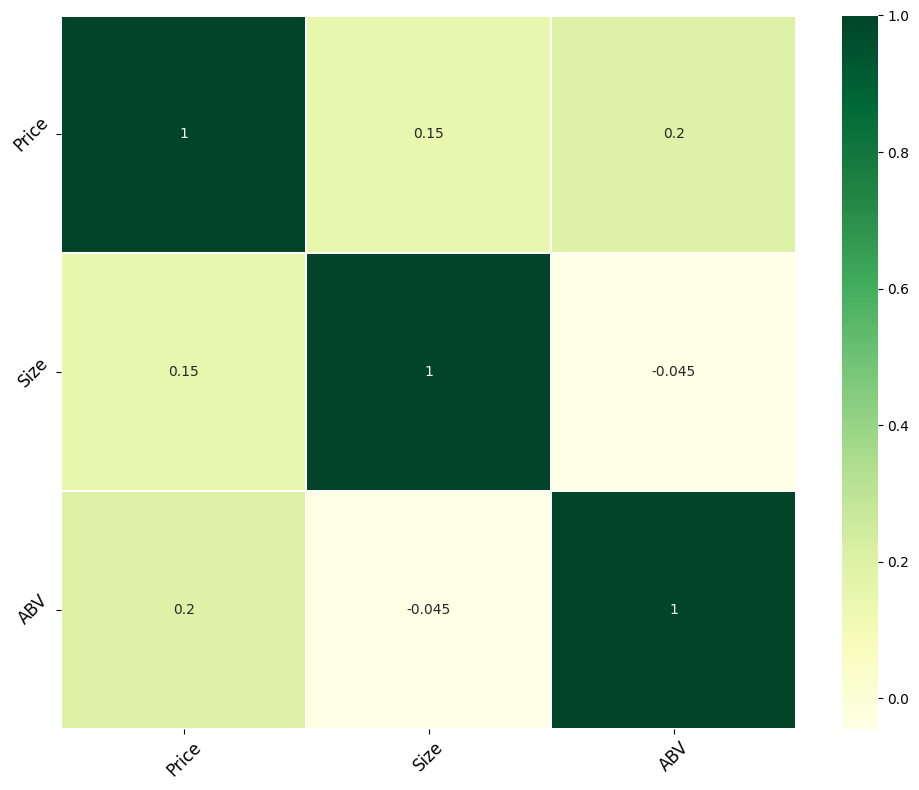

In [20]:
# We can link together the datasets by the product_code in both but that might be messyyyy but we might have to at some point
# Plot relationship between all variables of product_range
plt.figure(figsize=(10, 8))
sns.heatmap(product_range[['Price', 'Size', 'ABV']].corr(),linewidths=0.1, annot=True,cmap='YlGn')
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

We can see there's no strong correlation between any of the given variables, based on price, size, ABV. This is to be expected, since there's not many categories to consider. 

/var/folders/gm/n1_ws6nd71b6h3mc4nht_zzh0000gn/T/ipykernel_32147/3685113328.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(transactions.corr(),linewidths=0.1, annot=True,cmap='YlGn')


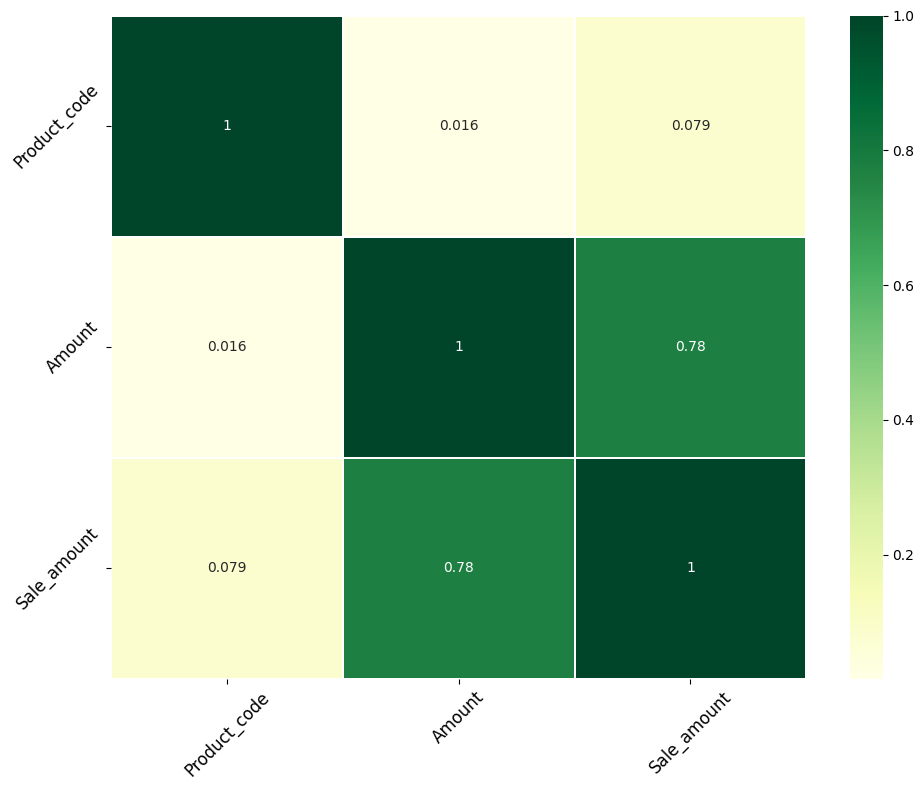

In [21]:
# Plot relationship between all variables of transactions
plt.figure(figsize=(10, 8))
sns.heatmap(transactions.corr(),linewidths=0.1, annot=True,cmap='YlGn')
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12, rotation=45) 
plt.show()

#  Make sure to note any strong correlations

### Linear Regression

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

split = int(product_range.shape[0]*0.8)

X = product_range[['Size', 'ABV']]
Y = product_range['Price']

X_train, X_test, y_train, y_true = train_test_split(X, Y, test_size = 0.8, random_state = 0)

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

Text(0, 0.5, 'Predicted')

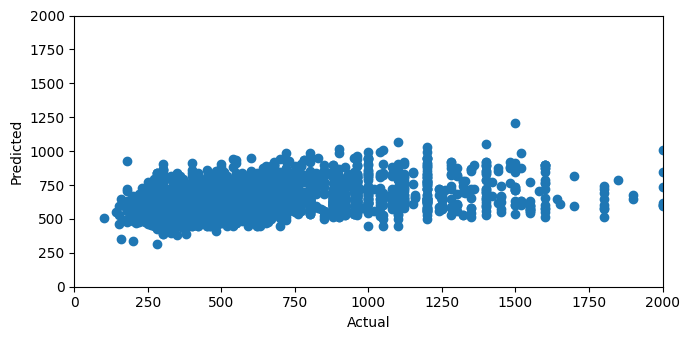

In [23]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,2000)
plt.ylim(0,2000)
plt.scatter(y_true ,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

This is the predicted labels being compared to the actual labels, in regards to price and with outliers > 2000 removed. It can be difficult to see, but most of the predictions are not close to the actual price or we would see a linear relationship (where predicted price matches actual price). This reinforces that price is dependent on more factors than ABV and size.

In [25]:
split2 = int(transactions.shape[0]*0.8)

X2 = transactions[['Product_code','Amount']]
Y2 = transactions['Sale_amount']

X2_train, X2_test, y2_train, y2_true = train_test_split(X2, Y2, test_size = 0.8, random_state = 0)

LR_model2 = LinearRegression()
LR_model2.fit(X2_train, y2_train)
y2_pred = LR_model2.predict(X2_test)

Text(0, 0.5, 'Predicted')

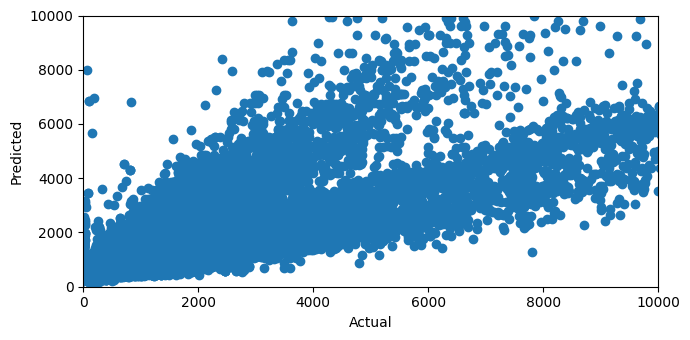

In [34]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.xlim(0,10000)
plt.ylim(0,10000)
plt.scatter(y2_true ,y2_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

This is the predicted labels being compared to the actual labels, in regards to sale amount(essentially the price) and with outliers > 10,000 removed. The plotted data seems to split and show two roughly linear relationships. This indicates that, although the price is dependent on the type of product and the amount sold, there are other variables that have an influence as well.  

# Proposed Solution
Because this is a regression problem, we are going to attempt to use multiple linear regression to train our model. Multiple linear regression allows us to predict continuous values (like the price of beer) when considering multiple independent variables (manufacturer, SKU, country of origin, SKU size, and alcohol by volume). Other models that could work include regular Linear Regression, polynomial regression for a polynomial relationship, or decision tree regression (which would be better suited with less independent variables). 

The libraries we will use are numpy, sklearn, and pandas.
- Clean data of missing values, NaN, and variables that we won’t be considering
- Check correlation of data via multiple scatter plots
- Split data into test/train set
- Formulate Multiple Linear Regression model
- Fit model to train data, test model on testing data
- Use Ordinary Least Squares to minimize the residual


If we see that the relationship between any of the independent variables and the price is different than expected, or if any assumptions surrounding linear regression are broken, we will consider changing our model to another one. To make our results more accurate, we will also experiment with different kinds of regularization (OLS, L1, L2, Lasso) and different regularization strengths.



# Evaluation Metrics
We will use the Mean Squared Error (MSE) to find the average difference between the actual and predicted values for craft beer prices, as it is the standard with Ordinary Least Squares. 

The equation for Mean Squared Error is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/ae01f23f2ed2814c7db94e1fdc952732f5ca533a)

where given a vector of $n$ observations from a sample taken from $n$ data points on all independent variables, with $Y$ being the observed values being predicted and $\hat{Y}$ being the predicted values.

# Preliminary results
- We should definitely merge both datasets via product_code to be able to make the best prediction possible
- We could select hyperparameters based on stronger relationships in either datasets
- The performance of the initial Linear Regression model on ABV, Price, and Size was unsuccessful; more variables are needed to be incorporated

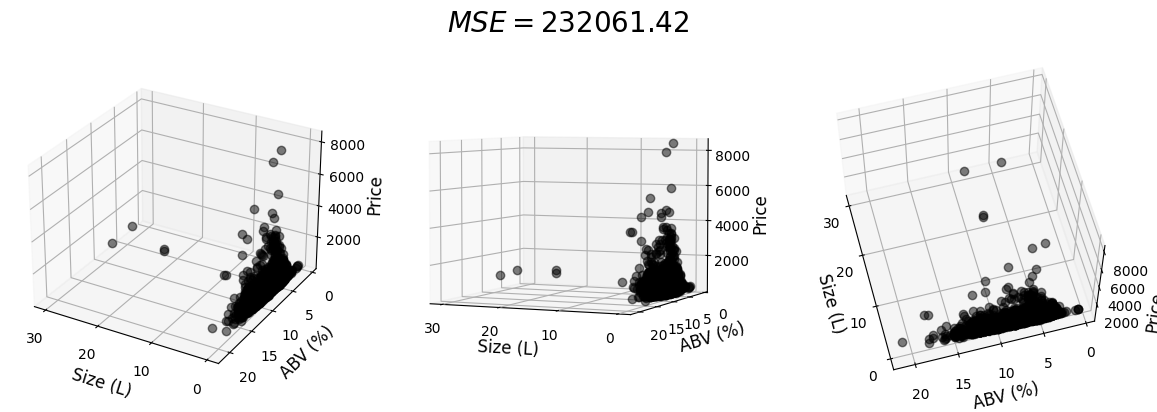

In [237]:
size = X['Size']
abv = X['ABV']
price = Y

plt.style.use('default')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

for ax in [ax1, ax2, ax3]:
    ax.plot(size, abv, price, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.set_xlabel('Size (L)', fontsize=12)
    ax.set_ylabel('ABV (%)', fontsize=12)
    ax.set_zlabel('Price', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$MSE = %.2f$' % mean_squared_error(y_true, y_pred), fontsize=20)

fig.tight_layout()

This is the relationship between size, ABV, and price as given by all the processed data. Our MSE score is 232061.42; not good as it does not indicate correlation, but we will analyze more variables later.

# Ethics & Privacy

Because our data sets do not include people’s personal data or identifying information, there are no pressing data privacy concerns regarding our project. The data we are using was willfully posted to the internet by the bar that collected the data on itself and its own sales history. In addition, because the purpose of the project is to predict prices for a specific product in a specific area, there are no concerns about unethical or offensive biases against any group. 

Russia has one of the highest alcoholism rates in the world. One possible ethical concern is that someone may be struggling with alcohol abuse and use our models to see when beer will be least expensive. This could cause emotional and physical harm to them and those around them. We will address this issue by including resources that people struggling with alcohol abuse can use to reach out for help. 

Another concern is that our model may be abused in the competitive market. Businesses could use our model to underprice beer for the purpose of driving competitors out of the market, which is unethical. 


# Team Expectations 

- Try your best to get your part of the work done by our weekly meeting time
- If you are unable to finish your part of the project, communicate beforehand
- If you need help, reach out 


# Project Timeline Proposal

| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/22  |  1 PM |  Edit, finalize, and submit proposal; Search for datasets   | Discuss Wrangling and possible analytical approaches; Assign group members to lead each specific part | 
| 2/28  |  10 AM |  Import & Wrangle Data, do some EDA | Review/Edit wrangling/EDA; Discuss Analysis Plan | 
| 3/8  | 1 PM  | Finalize wrangling/EDA; Begin programming for project  | Discuss/edit project code; Complete project   |
| 3/15  | 6 PM  | Complete analysis; Draft results/conclusion/discussion  | Discuss/edit full project  |
| 3/22  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="war"></a>1.[^](#war): “War in Ukraine Could Impact Beer Prices in US.” ABC7 Chicago, 27 Feb. 2022, https://abc7chicago.com/russia-ukraine-war-cost-of-beer-prices-craft/11603203/. <br> 
<a name="mccormick"></a>2.[^](#mccormick): McCormick, Tom, and Posted by Tom McCormick. “War in Ukraine Has Far Reaching Impact on Alcohol Beverage Industry.” ProBrewer, 1 Mar. 2022, https://www.probrewer.com/beverage-industry-news/international/war-in-ukraine-has-far-reaching-impact-on-alcohol-beverage-industry/. <br>
<a name="beeralytics"></a>3.[^](#beeralytics): “Beeralytics — A Guide to Analyzing Beer Prices from Web Data.” Towards Data Science, 23 March, 2020, https://towardsdatascience.com/beeralytics-a-guide-to-analyzing-beer-prices-from-web-data-37d4ba206071.<br>
<a name="jeevan"></a>4.[^](#jeevan): “[Project] Predicting Alcohol Quality Using Machine Learning - Part I.” UpLevel, 28 July 2020, https://projects.uplevel.work/features/predicting-alcohol-quality-using-machine-learning. <br>
<a name="forbes"></a>5.[^](#forbes): “Trends Affecting The Restaurant Industry In 2022” Forbes, 16 March 2022, https://www.forbes.com/sites/garyocchiogrosso/2022/03/16/trends-affecting-the-restaurant-industry-in-2022/ . <br>